## Missing Data Handler

**Introduction**

In this notebook we have multiple targets values where each target value is having different missing values than the others, a seperate model is build/trained to predict the missing values and posting the values to their respective position bases on the available data.

### Loading Packages


In [159]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import numpy as np

### Loading data

In [139]:
# Read the CSV file
data = pd.read_csv('AllData.csv')
data.head()

,Username,Group(Control=0; ADHD=1),Age,Gender,Highest_Education,A_Symptoms,H_Symptoms,Total_score,PWM_Symptoms
0,1,0.0,22,Female,Masters,2.0,0.0,2,20
1,2,0.0,30,Female,Undergraduate,6.0,0.0,6,27
2,3,1.0,23,Male,Masters,5.0,8.0,13,25
3,4,1.0,26,Female,Masters,10.0,2.0,12,30
4,5,1.0,20,Female,Undergraduate,9.0,7.0,16,26


### Data Analysis

In [140]:
data.describe(include = 'all')

,Username,Group(Control=0; ADHD=1),Age,Gender,Highest_Education,A_Symptoms,H_Symptoms,Total_score,PWM_Symptoms
count,228.00000,178.00000,228.000000,228,151,178.000000,178.000000,228.000000,228.000000
unique,NaN,NaN,NaN,2,5,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Female,Undergraduate,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,127,81,NaN,NaN,NaN,NaN
mean,114.50000,0.50000,25.399123,NaN,NaN,6.202247,5.073034,13.469298,17.951754
std,65.96211,0.50141,7.666128,NaN,NaN,4.205672,2.419379,4.418017,6.027276
min,1.00000,0.00000,18.000000,NaN,NaN,0.000000,0.000000,0.000000,4.000000
25%,57.75000,0.00000,21.000000,NaN,NaN,2.000000,4.000000,12.000000,14.000000
50%,114.50000,0.50000,23.000000,NaN,NaN,7.500000,6.000000,14.000000,17.000000
75%,171.25000,1.00000,28.000000,NaN,NaN,10.000000,6.000000,16.000000,21.000000


In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Username                  228 non-null    int64  
 1   Group(Control=0; ADHD=1)  178 non-null    float64
 2   Age                       228 non-null    int64  
 3   Gender                    228 non-null    object 
 4   Highest_Education         151 non-null    object 
 5   A_Symptoms                178 non-null    float64
 6   H_Symptoms                178 non-null    float64
 7   Total_score               228 non-null    int64  
 8   PWM_Symptoms              228 non-null    int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 16.2+ KB


In [142]:
data.isnull().sum()

Username                     0
Group(Control=0; ADHD=1)    50
Age                          0
Gender                       0
Highest_Education           77
A_Symptoms                  50
H_Symptoms                  50
Total_score                  0
PWM_Symptoms                 0
dtype: int64

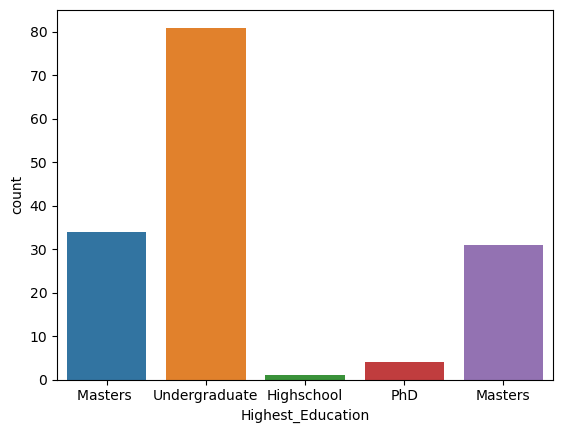

In [143]:
sns.countplot(x = data['Highest_Education'])
plt.show()

### Feature Engineering

In [144]:
# Separate the features and target variable
features = ['Age', 'Gender', 'Total_score', 'PWM_Symptoms']
target_columns = ['Group(Control=0; ADHD=1)', 'Highest_Education', 'A_Symptoms', 'H_Symptoms']
target = data[target_columns]

In [145]:
# Encode categorical features
label_encoder = LabelEncoder()
for column in ['Gender']:
    data[column] = label_encoder.fit_transform(data[column])

### Model Training

In [146]:
# categorical target columns
cat_columns = ['Group(Control=0; ADHD=1)', 'Highest_Education']

reg_param_grid = [
    {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'random_state': [42]
    },
    {
        'n_estimators': [50, 100],
        'max_depth': [None, 5],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 4],
        'random_state': [42]
    }
]

# Define the parameter grid to search
clf_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of decision trees
    'criterion': ['gini', 'entropy'],  # Split quality criterion
    'max_depth': [None, 5, 10],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'random_state': [42]  # Random seed for reproducibility
}
# Train a random forest classifier for each target column
classifiers = {}
for column in tqdm(target_columns, desc='Training models'):
    if column in cat_columns:
        rf = RandomForestClassifier()
        param_grid = clf_param_grid
    else:
        rf = RandomForestRegressor()
        param_grid = reg_param_grid
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
    grid_search.fit(data[features][:-data[column].isnull().sum()], data[column][:-data[column].isnull().sum()])
    # Get the best trained model
    classifiers[column] = grid_search.best_estimator_

Training models:  25%|██████▊                    | 1/4 [03:13<09:39, 193.29s/it]/Users/auk/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
Training models: 100%|███████████████████████████| 4/4 [17:13<00:00, 258.48s/it]


### Model Prediction

In [147]:
# Predict the missing values
for column in target_columns:
    missing_values = data[data[column].isnull()]
    if len(missing_values) > 0:
        predicted_values = classifiers[column].predict(missing_values[features])
        data.loc[data[column].isnull(), column] = predicted_values

In [148]:
# decode Gender to Male & Female
data['Gender'] = label_encoder.inverse_transform(data['Gender'])

In [164]:
# round the values 
data['A_Symptoms'] = data['A_Symptoms'].apply(lambda x: np.ceil(x))
data['H_Symptoms'] = data['H_Symptoms'].apply(lambda x: np.ceil(x))
# Calculate the 'H_Symptoms' column
data['H_Symptoms'] = data['Total_score'] - data['A_Symptoms']

In [165]:
# Save the updated data to a new CSV file
data.to_csv('filled_data.csv', index=False)

In [166]:
data.tail()

,Username,Group(Control=0; ADHD=1),Age,Gender,Highest_Education,A_Symptoms,H_Symptoms,Total_score,PWM_Symptoms
223,224,0.0,45,Male,Undergraduate,6.0,5.0,11,14
224,225,1.0,25,Male,Undergraduate,11.0,7.0,18,17
225,226,1.0,28,Male,Masters,9.0,5.0,14,16
226,227,1.0,35,Male,Undergraduate,7.0,7.0,14,9
227,228,0.0,30,Female,Masters,6.0,6.0,12,9
